# Introduction

This is a continuation of the speech emotion recognition model based on RAVDESS dataset. During this portion I will
be exploring different hyper-parameters and the final model to evaluate the emotion classes. A few thoughts, the datasets
available are not very abundant and emotion interpretation seems like an arbitrary subject. It would be interesting to
see how results differed if we had a large dataset with professional quality labeled emotion samples with varying 
languages, dialects, races, sexes and accents. Maybe in the future someone can tackle that since I could not find it. 
Even with such a dataset, I wonder if human experts would even be able to interpret the emotions correctly.

## Contents

* [Introduction](#Introduction)
    * [Imports](#Imports)
    * [About the RAVDESS dataset](#About_the_RAVDESS_dataset)
* [About the data](#About_the_data)
    * [Correlation](#Correlation)
    * [Distributions Of Feature Values](#Distributions_Of_Feature_Values)
* [Choosing the final model](#Choosing_the_final_model)
    * [GridSearchCV](#GridSearchCV)
    * [RandomizedSearch](#RandomizedSearch)
        * [RandomizedSearchCV with male dataset](#RandomizedSearchCV_with_male_dataset)
        * [RandomizedSearchCV with female dataset](#RandomizedSearchCV_with_female_dataset)        
    * [Multi Layer Perception Classifier - old method adapted](#Multi_Layer_Perception_Classifier_-_old_method_adapted)
    * [Multi-Layer Perceptron Classifier - new method](#Multi-Layer_Perceptron_Classifier_-_new_method)

## Imports

In [1]:
# Importing libraries necessary to perform analysis
import librosa
import librosa.display
import soundfile
import pandas as pd
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lightgbm as lgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import mpl_toolkits.mplot3d

from dotenv import load_dotenv, find_dotenv

import warnings

# Suppress specific warnings related to certain modules
warnings.filterwarnings('ignore', module='seaborn')
warnings.filterwarnings('ignore', module='pandas')
warnings.filterwarnings('ignore', module='lightgbm')

load_dotenv()
sound_path = os.getenv('audio_path')

## About the RAVDESS dataset<a id='About_the_RAVDESS_dataset'></a>

This dataset is pulled from the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). It has 
classifications that are contained in the file names. They are as follows:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

Academic citation

If you use the RAVDESS in an academic publication, please use the following citation: Livingstone SR, Russo FA (2018) 
    The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and 
        vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

All other attributions

If you use the RAVDESS in a form other than an academic publication, such as in a blog post, school project, or 
non-commercial product, please use the following attribution: "The Ryerson Audio-Visual Database of Emotional Speech 
    and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

# About the data<a id='About_the_data'></a>

*[Contents](#Contents)

In [2]:
data1 = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
df = pd.DataFrame(data1)
pd.set_option('display.max_columns', None)
df.head()

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_max,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-16.392443,202.98502,-645.92170,-7.125899,82.844154,0.365277,0.181984,3.290076,36.87685,-15.079271,0.568462,8.395280,1.881931,2.384150,-2.929066,16.196424,-35.155490,-0.093855,9.038805,-1.890271,2.538881,0.607089,0.141472,1.0,0.600354,0.236534,0.086949,-0.952044,0.007324,1.707622,1.860741e-18,0.000056,0.045920,3.904024,16.927513,24.848774,81.737506,4.558243,18.060076,19.179764,-0.332873,0.920353,2862.926393,7495.930442,1162.137023,2306.370804,1505.855829,1.652513,1.915730,5278.790509,11923.828125,1998.046875,4651.367188,2714.027774,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-16.195488,193.51984,-644.16350,-6.892159,83.358950,0.258790,-0.088001,3.281766,36.88804,-14.507144,0.626492,8.581219,1.857355,2.298338,-3.001566,15.750255,-34.858368,-0.140539,9.143971,-1.889248,2.497091,0.565118,0.135088,1.0,0.526963,0.247438,0.231975,-0.966832,0.008445,1.459130,1.702563e-18,0.000053,0.052460,3.737249,15.052235,25.445381,81.394861,5.744724,18.907480,19.201790,0.101690,2.415374,2856.267937,7574.012464,1196.255587,2532.671446,1438.028687,1.745676,2.597192,5509.765625,11837.890625,2041.015625,5156.250000,2578.736315,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-15.760641,209.64243,-599.33685,-6.811954,80.973440,0.349635,-0.079561,3.183938,33.61964,-16.218931,0.521331,8.188260,1.812531,2.258523,-2.733035,16.290403,-33.561646,-0.003302,8.798903,-1.845969,2.446758,0.566147,0.085513,1.0,0.543228,0.236025,0.195621,-0.746908,0.011151,1.726585,2.294504e-18,0.000077,0.065326,3.784763,16.238434,25.271402,84.231012,3.335950,18.387247,19.357776,-0.364876,1.243544,3147.076638,9735.443474,1074.722832,2347.152059,2109.463110,1.894945,2.580431,5705.295139,12525.390625,1890.625000,5059.570312,3023.452212,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-16.046278,215.37698,-620.35815,-7.427359,81.609146,0.240670,-0.124088,3.185494,34.72454,-14.316382,0.496043,8.297734,1.826856,2.279578,-2.840508,17.101452,-35.499820,-0.068866,8.946567,-1.873974,2.477692,0.605738,0.112530,1.0,0.586911,0.229687,0.158463,-0.645343,0.010260,1.904755,2.764673e-18,0.000067,0.061361,3.518846,13.859685,25.348465,82.521337,4.348983,19.184102,19.175904,-0.306959,0.998655,3128.884756,9390.101251,1315.933093,2504.069840,2070.285142,1.732141,1.991167,5710.712139,12482.421875,1847.656250,5134.765625,3071.179190,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-16.582544,205.08063,-692.11237,-

### Adding actor number to dataframe

In [4]:
df = pd.DataFrame(data1)

# Modified determine_actor function to work with dataframe values
def determine_actor_from_filename(filename):
    try:
        # Assuming the filename structure doesn't change and the actor number is always in the same position
        number = int(filename.split('-')[6].rstrip('.wav'))
        return number
    except Exception as e:
        # Log the error or handle it as needed
        return 'Unknown'

# Applying the modified function to the dataframe and creating a new column with the results
df['actor_number'] = df['filename'].apply(determine_actor_from_filename)

In [5]:
df

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_max,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis,actor_number
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-16.392443,202.98502,-645.92170,-7.125899,82.844154,0.365277,0.181984,3.290076,36.876850,-15.079271,0.568462,8.395280,1.881931,2.384150,-2.929066,16.196424,-35.155490,-0.093855,9.038805,-1.890271,2.538881,0.607089,0.141472,1.0,0.600354,0.236534,0.086949,-0.952044,0.007324,1.707622,1.860741e-18,0.000056,0.045920,3.904024,16.927513,24.848774,81.737506,4.558243,18.060076,19.179764,-0.332873,0.920353,2862.926393,7495.930442,1162.137023,2306.370804,1505.855829,1.652513,1.915730,5278.790509,11923.828125,1998.046875,4651.367188,2714.027774,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986,1
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-16.195488,193.51984,-644.16350,-6.892159,83.358950,0.258790,-0.088001,3.281766,36.888040,-14.507144,0.626492,8.581219,1.857355,2.298338,-3.001566,15.750255,-34.858368,-0.140539,9.143971,-1.889248,2.497091,0.565118,0.135088,1.0,0.526963,0.247438,0.231975,-0.966832,0.008445,1.459130,1.702563e-18,0.000053,0.052460,3.737249,15.052235,25.445381,81.394861,5.744724,18.907480,19.201790,0.101690,2.415374,2856.267937,7574.012464,1196.255587,2532.671446,1438.028687,1.745676,2.597192,5509.765625,11837.890625,2041.015625,5156.250000,2578.736315,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776,1
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-15.760641,209.64243,-599.33685,-6.811954,80.973440,0.349635,-0.079561,3.183938,33.619640,-16.218931,0.521331,8.188260,1.812531,2.258523,-2.733035,16.290403,-33.561646,-0.003302,8.798903,-1.845969,2.446758,0.566147,0.085513,1.0,0.543228,0.236025,0.195621,-0.746908,0.011151,1.726585,2.294504e-18,0.000077,0.065326,3.784763,16.238434,25.271402,84.231012,3.335950,18.387247,19.357776,-0.364876,1.243544,3147.076638,9735.443474,1074.722832,2347.152059,2109.463110,1.894945,2.580431,5705.295139,12525.390625,1890.625000,5059.570312,3023.452212,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514,1
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-16.046278,215.37698,-620.35815,-7.427359,81.609146,0.240670,-0.124088,3.185494,34.724540,-14.316382,0.496043,8.297734,1.826856,2.279578,-2.840508,17.101452,-35.499820,-0.068866,8.946567,-1.873974,2.477692,0.605738,0.112530,1.0,0.586911,0.229687,0.158463,-0.645343,0.010260,1.904755,2.764673e-18,0.000067,0.061361,3.518846,13.859685,25.348465,82.521337,4.348983,19.184102,19.175904,-0.306959,0.998655,3128.884756,9390.101251,1315.933093,2504.069840,2070.285142,1.732141,1.991167,5710.712139,12482.421875,1847.656250,5134.765625,3071.179190,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144,1
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-16.5825

### Rearranging columns

In [6]:
# Getting a list of current dataframe columns
cols = list(df.columns)

# Remove 'actor_number' from its current position
cols.remove('actor_number')

# Insert 'actor_number' at the desired position
cols.insert(8, 'actor_number')

# Reordering the dataframe based on the new columns order
df = df[cols]

In [7]:
# Now, 'actor_number' should be at the 9th position
df

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,actor_number,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_max,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,1,-16.392443,202.98502,-645.92170,-7.125899,82.844154,0.365277,0.181984,3.290076,36.876850,-15.079271,0.568462,8.395280,1.881931,2.384150,-2.929066,16.196424,-35.155490,-0.093855,9.038805,-1.890271,2.538881,0.607089,0.141472,1.0,0.600354,0.236534,0.086949,-0.952044,0.007324,1.707622,1.860741e-18,0.000056,0.045920,3.904024,16.927513,24.848774,81.737506,4.558243,18.060076,19.179764,-0.332873,0.920353,2862.926393,7495.930442,1162.137023,2306.370804,1505.855829,1.652513,1.915730,5278.790509,11923.828125,1998.046875,4651.367188,2714.027774,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,1,-16.195488,193.51984,-644.16350,-6.892159,83.358950,0.258790,-0.088001,3.281766,36.888040,-14.507144,0.626492,8.581219,1.857355,2.298338,-3.001566,15.750255,-34.858368,-0.140539,9.143971,-1.889248,2.497091,0.565118,0.135088,1.0,0.526963,0.247438,0.231975,-0.966832,0.008445,1.459130,1.702563e-18,0.000053,0.052460,3.737249,15.052235,25.445381,81.394861,5.744724,18.907480,19.201790,0.101690,2.415374,2856.267937,7574.012464,1196.255587,2532.671446,1438.028687,1.745676,2.597192,5509.765625,11837.890625,2041.015625,5156.250000,2578.736315,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,1,-15.760641,209.64243,-599.33685,-6.811954,80.973440,0.349635,-0.079561,3.183938,33.619640,-16.218931,0.521331,8.188260,1.812531,2.258523,-2.733035,16.290403,-33.561646,-0.003302,8.798903,-1.845969,2.446758,0.566147,0.085513,1.0,0.543228,0.236025,0.195621,-0.746908,0.011151,1.726585,2.294504e-18,0.000077,0.065326,3.784763,16.238434,25.271402,84.231012,3.335950,18.387247,19.357776,-0.364876,1.243544,3147.076638,9735.443474,1074.722832,2347.152059,2109.463110,1.894945,2.580431,5705.295139,12525.390625,1890.625000,5059.570312,3023.452212,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,1,-16.046278,215.37698,-620.35815,-7.427359,81.609146,0.240670,-0.124088,3.185494,34.724540,-14.316382,0.496043,8.297734,1.826856,2.279578,-2.840508,17.101452,-35.499820,-0.068866,8.946567,-1.873974,2.477692,0.605738,0.112530,1.0,0.586911,0.229687,0.158463,-0.645343,0.010260,1.904755,2.764673e-18,0.000067,0.061361,3.518846,13.859685,25.348465,82.521337,4.348983,19.184102,19.175904,-0.306959,0.998655,3128.884756,9390.101251,1315.933093,2504.069840,2070.285142,1.732141,1.991167,5710.712139,12482.421875,1847.656250,5134.765625,3071.179190,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,1,-16.58

## Correlation

In [8]:
df.iloc[:,9:].corr()

,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_max,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
mfcc_mean,1.000000,-0.130530,0.545320,0.793668,-0.666975,-0.012438,0.010572,-0.703229,-0.481893,0.078068,-0.374642,-0.633796,-0.623230,-0.595497,0.626805,-0.159048,0.455374,-0.171573,-0.595989,0.570655,-0.453987,0.103756,-0.006999,NaN,0.119305,-0.039241,-0.120132,-0.107701,0.457817,0.371087,0.347396,0.482156,0.402793,0.042321,0.034912,0.092757,-0.259593,0.028851,0.037832,0.177584,-0.073549,0.025064,0.066353,-0.257651,0.139930,0.290870,-0.350858,-0.086639,0.084026,0.145787,-0.136398,0.223879,0.213703,-0.370159,-0.010200,0.227040,0.583611,0.568527,0.563425,0.567429,0.557424,0.038503,-0.062392,-0.104321,-0.260073,0.043147,0.231084,-0.319914,-0.119144,0.018235
mfcc_max,-0.130530,1.000000,-0.474049,-0.280082,0.468070,0.546043,0.383828,-0.070412,0.241837,-0.739012,-0.039346,0.088775,0.295757,0.452907,-0.420155,0.741095,-0.495916,0.471678,0.498209,-0.522410,0.678584,0.591368,0.510922,NaN,0.575055,-0.565197,-0.500231,-0.364647,-0.442749,-0.402242,-0.288719,-0.253732,-0.428064,-0.288914,-0.268982,-0.486003,-0.078754,0.382502,-0.457006,-0.581663,0.090466,-0.310135,-0.606783,-0.087317,-0.620432,-0.705633,0.181990,0.120910,-0.011613,-0.623830,-0.323841,-0.579255,-0.591382,0.349884,0.096440,-0.149956,-0.571784,-0.556667,-0.457395,-0.560052,-0.557822,-0.043317,0.005741,-0.427632,-0.094001,-0.555641,-0.662021,0.012808,0.100101,-0.001521
mfcc_min,0.545320,-0.474049,1.000000,0.263903,-0.877602,-0.237211,-0.412573,-0.617213,-0.899514,0.470459,0.105780,-0.767952,-0.756685,-0.815748,0.875804,-0.336846,0.970728,-0.430141,-0.904222,0.793546,-0.795952,-0.388942,-0.307555,NaN,-0.387754,0.311700,0.389509,0.150367,0.535194,0.435845,0.493449,0.475194,0.481224,-0.155988,-0.192791,0.446178,-0.144398,-0.119192,0.383658,0.501495,-0.187424,0.190232,0.351688,-0.080499,0.513010,0.500206,-0.259982,0.024213,0.094616,0.356989,0.089257,0.513510,0.356484,-0.386913,0.096864,0.250617,0.708925,0.651496,0.768419,0.707763,0.631420,-0.029334,-0.093425,0.092316,-0.104490,0.486286,0.413593,-0.218152,0.033891,0.124685
mfcc_median,0.793668,-0.280082,0.263903,1.000000,-0.357423,-0.194923,0.017181,-0.213453,-0.116464,0.249760,-0.403609,-0.175804,-0.306371,-0.358883,0.306604,-0.279260,0.216551,-0.204989,-0.317189,0.359633,-0.346728,0.012110,-0.155482,NaN,0.050638,0.144652,-0.121166,-0.081441,0.311169,0.258922,0.221623,0.299655,0.278054,0.288357,0.286972,0.034502,-0.210749,-0.086836,-0.000088,0.205249,0.043542,0.048291,0.204373,-0.177857,0.158293,0.400515,-0.292913,-0.241339,-0.020653,0.291460,0.008250,0.199507,0.360252,-0.276473,-0.203951,0.090574,0.408965,0.412915,0.375166,0.390656,0.408941,0.062990,-0.034138,0.097559,-0.156519,0.064504,0.366026,-0.195940,-0.233254,-0.094348
mfcc_std,-0.666975,0.468070,-0.877602,-0.357423,1.000000,0.214916,0.218836,0.785486,0.773392,-0.399690,0.016886,0.888388,0.866180,0.891348,-0.986437,0.299321,-0.812077,0.396481,0.982832,-0.892217,0.822337,0.206903,0.245971,NaN,0.200072,-0.204275,-0.199430,-0.010720,-0.605158,-0.496049,-0.458660,-0.550120,-0.541762,-0.013711,0.012941,-0.326111,0.131292,0.171304,-0.231179,-0.561621,0.038891,-0.21146

## Distributions Of Feature Values<a id='Distributions_Of_Feature_Values'></a>

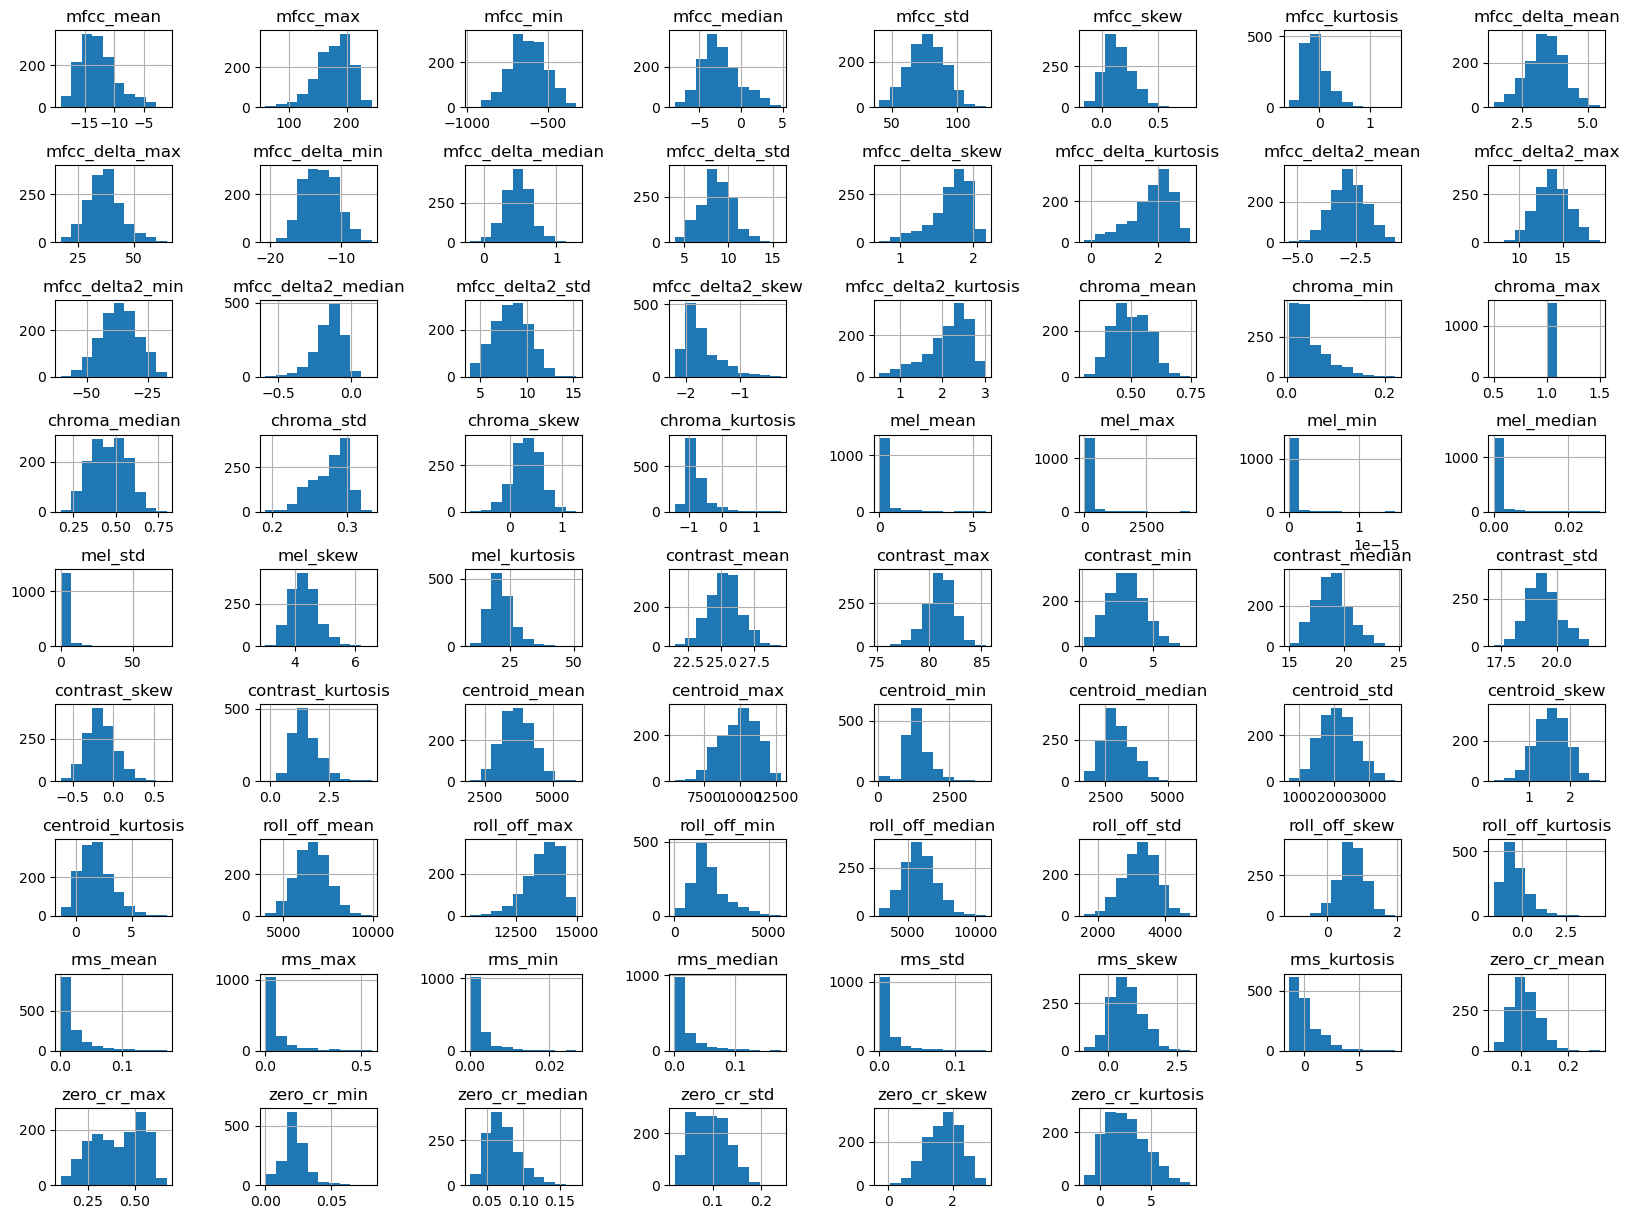

In [9]:
df.iloc[:,9:].hist(figsize=(20,15))
plt.subplots_adjust(hspace=0.75, wspace=0.75);

# Choosing the final model<a id='Choosing_the_final_model'></a>

## Multi Layer Perception Classifier - old method adapted<a id='Multi_Layer_Perception_Classifier_-_old_method_adapted'></a>

*[Contents](#Contents)

In [9]:
# Extended feature extraction function
def extract_feature(signal, sample_rate, mfcc, chroma, mel, contrast, centroid, roll_off, bandwidth, energy, rms, delta_mfccs, delta2_mfccs):

    X = signal

    result = np.array([])

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))

        if delta_mfccs:
            if mfccs.shape[0] > 1:  # Check if there are enough frames
                delta_mfccs = np.mean(librosa.feature.delta(mfccs).T, axis=0)
                result = np.hstack((result, delta_mfccs)) 
            else:
                # Handle the case where there are not enough frames
                # For example, append zeros or handle it as required
                pass

        if delta2_mfccs:
            if mfccs.shape[0] > 1:  # Check if there are enough frames
                delta2_mfccs = np.mean(librosa.feature.delta(mfccs, order=2).T, axis=0)
                result = np.hstack((result, delta2_mfccs)) 
            else:
                # Handle the case where there are not enough frames
                # For example, append zeros or handle it as required
                pass
    if chroma:
        stft=np.abs(librosa.stft(X))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, contrast))
    if centroid:
        centroid = np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, centroid))
    if roll_off:
        roll_off = np.mean(librosa.feature.spectral_rolloff(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, roll_off))
    if bandwidth:
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, bandwidth))
    if energy:
        energy = np.array([np.sum(np.square(X))])
        result = np.hstack((result, energy))
    if rms:
        rms = np.mean(librosa.feature.rms(y=X).T, axis=0)
        result = np.hstack((result, rms))

    return result

In [10]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe
# observed_emotions=['calm', 'happy', 'angry', 'disgust']
# observed_emotions=['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust']
observed_emotions=['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
# observed_emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [11]:
# load, segment and process data
# Best results: Accuracy of male scaled: 71.11%, Accuracy of female scaled: 78.33%
# with test_size=0.2, mfcc=True, delta_mfccs=True, delta2_mfccs=True, chroma=True, mel=True, contrast=False, 
#      centroid=False, roll_off=False, bandwidth=False, energy=False, rms=True
def load_data(test_size=0.2, mfcc=True, delta_mfccs=True, delta2_mfccs=True, chroma=True, mel=True, contrast=False, 
              centroid=False, roll_off=False, bandwidth=False, energy=False, rms=True):
    X_male, y_male = [], []
    X_female, y_female = [], []
    for file in glob.glob(f'{sound_path}/ravdess-data/Actor_*/*.wav'):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        actor_number = int(file_name.split("-")[-1].split(".")[0])  # Extract actor number from filename

        if emotion not in observed_emotions:
            continue

        # Load the audio file
        signal, sample_rate = librosa.load(file, sr=None)

        # Remove silent parts
        non_silent_intervals = librosa.effects.split(signal, top_db=30)  # top_db can be adjusted
        non_silent_signal = np.concatenate([signal[start:end] for start, end in non_silent_intervals])

        # Extract features from the entire non-silent signal
        feature = extract_feature(non_silent_signal, sample_rate, mfcc=mfcc, chroma=chroma, mel=mel, contrast=contrast, centroid=centroid, roll_off=roll_off, bandwidth=bandwidth, energy=energy, rms=rms, delta_mfccs=delta_mfccs, delta2_mfccs=delta2_mfccs)
        if actor_number % 2 == 0:  # Female actors have even numbers
            X_female.append(feature)
            y_female.append(emotion)
        else:  # Male actors have odd numbers
            X_male.append(feature)
            y_male.append(emotion)

    # Splitting the datasets into train and test sets
    X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(np.array(X_male), y_male, test_size=test_size)
    X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(np.array(X_female), y_female, test_size=test_size)

    return (X_train_male, X_test_male, y_train_male, y_test_male), (X_train_female, X_test_female, y_train_female, y_test_female)


In [12]:
# from sklearn.decomposition import PCA      # performance suffered with PCA, removed

# Split the datasets into male and female parts
(X_train_male, X_test_male, y_train_male, y_test_male), (X_train_female, X_test_female, y_train_female, y_test_female) = load_data(test_size=0.25)

# Initialize separate scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_male_scaled = scaler_male.fit_transform(X_train_male)
X_test_male_scaled = scaler_male.transform(X_test_male)

# Scale the female datasets
X_train_female_scaled = scaler_female.fit_transform(X_train_female)
X_test_female_scaled = scaler_female.transform(X_test_female)

In [13]:
# Get the shape of the regular training and testing datasets
print((X_train_male.shape[0], X_test_male.shape[0]))
print((X_train_female.shape[0], X_test_female.shape[0]))

(504, 168)
(504, 168)


In [14]:
# Get the shape of the Scaled training and testing datasets
print((X_train_male_scaled.shape[0], X_test_male.shape[0]))
print((X_train_female_scaled.shape[0], X_test_female.shape[0]))

(504, 168)
(504, 168)


In [15]:
# Get the number of regular features extracted
print(f'Features extracted: {X_train_male.shape[1]}')
print(f'Features extracted: {X_train_female.shape[1]}')

Features extracted: 183
Features extracted: 183


In [16]:
# Get the number of Scaled features extracted
print(f'Features extracted: {X_train_male_scaled.shape[1]}')
print(f'Features extracted: {X_train_female_scaled.shape[1]}')

Features extracted: 183
Features extracted: 183


#### Modeling, fitting and predicting male, female, male scaled, and female scaled

In [17]:
# # Initialize the Multi Layer Perceptron Classifier      # old parameters
# model_male=MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), learning_rate = 'adaptive', max_iter = 500)
# model_female=MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), learning_rate = 'adaptive', max_iter = 500)
# model_male_scaled=MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), learning_rate = 'adaptive', max_iter = 500)
# model_female_scaled=MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), learning_rate = 'adaptive', max_iter = 500)

In [18]:
# Initialize the Multi Layer Perceptron Classifier  
# Best results: Accuracy of male: 68.89%, Accuracy of female: 68.33%
#               Accuracy of male scaled: 73.21%, Accuracy of female scaled: 78.57%
# alpha=0.385, activation='relu', solver='adam', 
#                                  learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
#                                  hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=4000
model_male=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)
model_female=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)
model_male_scaled=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)
model_female_scaled=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)

In [19]:
# Train the model      # performance suffered with PCA, removed
model_male.fit(X_train_male, y_train_male)
model_female.fit(X_train_female, y_train_female)
model_male_scaled.fit(X_train_male_scaled, y_train_male)
model_female_scaled.fit(X_train_female_scaled, y_train_female)

MLPClassifier(alpha=0.385, batch_size=163, hidden_layer_sizes=(300,),
              learning_rate_init=0.0006, max_iter=2000)

In [20]:
# Predict for the test set      # performance suffered with PCA, removed
y_pred_m = model_male.predict(X_test_male)
y_pred_f = model_female.predict(X_test_female)
y_pred_m_sc = model_male_scaled.predict(X_test_male_scaled)
y_pred_f_sc = model_female_scaled.predict(X_test_female_scaled)

In [21]:
# Calculate the accuracy of our model      # performance suffered with PCA, removed
accuracy_m = accuracy_score(y_true = y_test_male, y_pred = y_pred_m)
accuracy_f = accuracy_score(y_true = y_test_female, y_pred = y_pred_f)
accuracy_m_sc = accuracy_score(y_true = y_test_male, y_pred = y_pred_m_sc)
accuracy_f_sc = accuracy_score(y_true = y_test_female, y_pred = y_pred_f_sc)

# Print the results
print("\nExample Classification Report for male:")
print(classification_report(y_test_male, model_male.predict(X_test_male)))
print("\nExample Confusion Matrix for male:")
print(confusion_matrix(y_test_male, model_male.predict(X_test_male)))
print()
print("Accuracy of male: {:.2f}%".format(accuracy_m*100))
print()
print()
print("\nExample Classification Report for female:")
print(classification_report(y_test_female, model_female.predict(X_test_female)))
print("\nExample Confusion Matrix for female:")
print(confusion_matrix(y_test_female, model_female.predict(X_test_female)))
print()
print("Accuracy of female: {:.2f}%".format(accuracy_f*100))
print()
print()
print("\nExample Classification Report for male scaled:")
print(classification_report(y_test_male, model_male_scaled.predict(X_test_male_scaled)))
print("\nExample Confusion Matrix for male scaled:")
print(confusion_matrix(y_test_male, model_male_scaled.predict(X_test_male_scaled)))
print()
print("Accuracy of male scaled: {:.2f}%".format(accuracy_m_sc*100))
print()
print()
print("\nExample Classification Report for female scaled:")
print(classification_report(y_test_female, model_female_scaled.predict(X_test_female_scaled)))
print("\nExample Confusion Matrix for female scaled:")
print(confusion_matrix(y_test_female, model_female_scaled.predict(X_test_female_scaled)))
print()
print("Accuracy of female scaled: {:.2f}%".format(accuracy_f_sc*100))


Example Classification Report for male:
              precision    recall  f1-score   support

       angry       0.93      0.58      0.72        24
        calm       0.73      0.85      0.79        26
     disgust       0.39      0.75      0.51        16
     fearful       0.82      0.36      0.50        25
       happy       0.50      0.52      0.51        25
         sad       0.55      0.55      0.55        31
   surprised       0.71      0.81      0.76        21

    accuracy                           0.62       168
   macro avg       0.66      0.63      0.62       168
weighted avg       0.67      0.62      0.62       168


Example Confusion Matrix for male:
[[14  0  2  0  5  2  1]
 [ 0 22  2  0  0  1  1]
 [ 0  0 12  0  0  3  1]
 [ 0  1  6  9  5  4  0]
 [ 1  2  2  1 13  4  2]
 [ 0  4  5  1  2 17  2]
 [ 0  1  2  0  1  0 17]]

Accuracy of male: 61.90%



Example Classification Report for female:
              precision    recall  f1-score   support

       angry       0.82      0.

#### Cross-Validation

*[Contents](#Contents)

In [22]:
# Perform 10-fold cross-validation
cv_scores_m = cross_val_score(model_male, X_train_male, y_train_male, cv=10, n_jobs=-1)

# Output the average score from cross-validation
print(f'Average CV Score for male: {np.mean(cv_scores_m)}')

Average CV Score for male: 0.6625490196078432


In [23]:
# Perform 10-fold cross-validation
cv_scores_f = cross_val_score(model_female, X_train_female, y_train_female, cv=10, n_jobs=-1)

# Output the average score from cross-validation
print(f'Average CV Score for female: {np.mean(cv_scores_f)}')

Average CV Score for female: 0.7122745098039215


In [24]:
# Perform 10-fold cross-validation
cv_scores_m_sc = cross_val_score(model_male_scaled, X_train_male_scaled, y_train_male, cv=10, n_jobs=-1)

# Output the average score from cross-validation
print(f'Average CV Score for scaled male: {np.mean(cv_scores_m_sc)}')

Average CV Score for scaled male: 0.6884313725490195


In [25]:
# Perform 10-fold cross-validation
cv_scores_f_sc = cross_val_score(model_female_scaled, X_train_female_scaled, y_train_female, cv=10, n_jobs=-1)

# Output the average score from cross-validation
print(f'Average CV Score for scaled female: {np.mean(cv_scores_f_sc)}')

Average CV Score for scaled female: 0.7381568627450981


### Thoughts on this method

This was a simple example I found online to start this project (https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/). It was to extract features but they were limited to just a few metrics and only 
an outline of the possibilities of the project. I expanded on the process to, in hopes, get better results. 
The addition of the new features helped achieve a similar accuracy but with 7 out of the 8 classes instead 
of just 4. While it's still not achieving great results, it is an improvement in my eyes. One downside that 
I just learned from my mentor is that this process is flawed due to data leakage. There are repeated phrases 
and without properly splitting the actors for the train and test sets, the model will identify the actor's 
previous statements and falsely increase results.

## GridSearchCV<a id='GridSearchCV'></a>

In these next few sections I'm going to try to find the best hyper-parameters with GridSearch and RandomizedSearch for the final model.

*[Contents](#Contents)

In [26]:
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [27]:
# Encoding categorical features (if they are not already encoded)
df['actor_gender'] = df['actor_gender'].map({1: 0, 2: 1})

df_male = df[df['actor_gender'] == 0]
df_female = df[df['actor_gender'] == 1]

In [28]:
# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

In [29]:
# feature_male = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 
#                 'mel_median', 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
#                 'rms_mean', 'zero_cr_mean']
# feature_female = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 
#                   'mel_median', 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
#                   'rms_mean', 'zero_cr_mean']
feature_male = df.columns[9:]
feature_female = df.columns[9:]
feature_female

Index(['mfcc_mean', 'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std',
       'mfcc_skew', 'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max',
       'mfcc_delta_min', 'mfcc_delta_median', 'mfcc_delta_std',
       'mfcc_delta_skew', 'mfcc_delta_kurtosis', 'mfcc_delta2_mean',
       'mfcc_delta2_max', 'mfcc_delta2_min', 'mfcc_delta2_median',
       'mfcc_delta2_std', 'mfcc_delta2_skew', 'mfcc_delta2_kurtosis',
       'chroma_mean', 'chroma_min', 'chroma_max', 'chroma_median',
       'chroma_std', 'chroma_skew', 'chroma_kurtosis', 'mel_mean', 'mel_max',
       'mel_min', 'mel_median', 'mel_std', 'mel_skew', 'mel_kurtosis',
       'contrast_mean', 'contrast_max', 'contrast_min', 'contrast_median',
       'contrast_std', 'contrast_skew', 'contrast_kurtosis', 'centroid_mean',
       'centroid_max', 'centroid_min', 'centroid_median', 'centroid_std',
       'centroid_skew', 'centroid_kurtosis', 'roll_off_mean', 'roll_off_max',
       'roll_off_min', 'roll_off_median', 'roll_off_std', 'roll_

In [30]:
from sklearn.model_selection import GridSearchCV

# Splitting actors for training and testing
train_male = [1, 3, 5, 13, 15, 17, 19, 21, 23]
test_male = [7, 9, 11]

# Split the dataframe based on actor numbers
train_df_m = df_male[df_male['actor_number'].isin(train_male)]
test_df_m = df_male[df_male['actor_number'].isin(test_male)]

# Define features and target for the train and test sets
X_train_male = train_df_m[feature_male]
y_train_male = train_df_m['emotion']
X_test_male = test_df_m[feature_male]
y_test_male = test_df_m['emotion']

# Define the parameter grid
param_grid_m = {
    'mlp__hidden_layer_sizes': [(600, ), (900, ), (1200, )],  # (300, ) was the best (vs. (50, ) through (500, 750))
    'mlp__activation': ['tanh', 'relu'],  # Using 'relu' yielded best results (vs. 'identity', 'logistic', 'tanh')
    'mlp__solver': ['adam', 'lbfgs'],  # Using 'sgd' yielded best results (vs. 'lbfgs', 'adam')
    'mlp__alpha': np.linspace(1.4, 1.8, 5),  # 0.6 was the best from multiple similar tests
    'mlp__learning_rate_init': np.linspace(0.0003, 0.0007, 5),  # 0.0212 was best
    'mlp__batch_size': [163],  # 163, was best
    'mlp__max_iter': [2000]  # 1000 best for max_iter
}

# Creating a pipeline that first applies the StandardScaler and then fits the MLPClassifier
grid_pipe_m = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(alpha=1.3, activation='tanh', solver='adam', 
                                 learning_rate_init=0.0004, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000))
])

# Create GridSearchCV object
grid_search_m = GridSearchCV(grid_pipe_m, param_grid_m, n_jobs=-1, cv=3, scoring='accuracy')

# Fit grid_search to the data
grid_search_m.fit(X_train_male, y_train_male)

# Output the best parameters and best score
print("Best Parameters:", grid_search_m.best_params_)
print("Best Score:", grid_search_m.best_score_)

# Evaluate the best model
best_grid_m = grid_search_m.best_estimator_
y_pred_male = best_grid_m.predict(X_test_male)
print(confusion_matrix(y_test_male, y_pred_male))
print(classification_report(y_test_male, y_pred_male))

Best Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 1.4, 'mlp__batch_size': 163, 'mlp__hidden_layer_sizes': (600,), 'mlp__learning_rate_init': 0.0003, 'mlp__max_iter': 2000, 'mlp__solver': 'adam'}
Best Score: 0.4603174603174603
[[13  1  3  2  3  2  0]
 [ 0 19  1  0  0  4  0]
 [ 1  4 13  1  0  5  0]
 [ 0  5  0 12  5  1  1]
 [ 0  3  0  1 16  4  0]
 [ 0 11  0  3  2  8  0]
 [ 0  0  4  0  4  7  9]]
              precision    recall  f1-score   support

       angry       0.93      0.54      0.68        24
        calm       0.44      0.79      0.57        24
     disgust       0.62      0.54      0.58        24
     fearful       0.63      0.50      0.56        24
       happy       0.53      0.67      0.59        24
         sad       0.26      0.33      0.29        24
   surprised       0.90      0.38      0.53        24

    accuracy                           0.54       168
   macro avg       0.62      0.54      0.54       168
weighted avg       0.62      0.54      0.54       168


## RandomizedSearch<a id='RandomizedSearch'></a>

*[Contents](#Contents)

In [9]:
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [10]:
# Encoding categorical features (if they are not already encoded)
df['actor_gender'] = df['actor_gender'].map({1: 0, 2: 1})

df_male = df[df['actor_gender'] == 0]
df_female = df[df['actor_gender'] == 1]

In [11]:
# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

In [12]:
# feature_male = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 
#                 'mel_median', 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
#                 'rms_mean', 'zero_cr_mean']
# feature_female = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 
#                   'mel_median', 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
#                   'rms_mean', 'zero_cr_mean']
feature_male = df.columns[9:]
feature_female = df.columns[9:]
feature_female

Index(['mfcc_mean', 'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std',
       'mfcc_skew', 'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max',
       'mfcc_delta_min', 'mfcc_delta_median', 'mfcc_delta_std',
       'mfcc_delta_skew', 'mfcc_delta_kurtosis', 'mfcc_delta2_mean',
       'mfcc_delta2_max', 'mfcc_delta2_min', 'mfcc_delta2_median',
       'mfcc_delta2_std', 'mfcc_delta2_skew', 'mfcc_delta2_kurtosis',
       'chroma_mean', 'chroma_min', 'chroma_max', 'chroma_median',
       'chroma_std', 'chroma_skew', 'chroma_kurtosis', 'mel_mean', 'mel_max',
       'mel_min', 'mel_median', 'mel_std', 'mel_skew', 'mel_kurtosis',
       'contrast_mean', 'contrast_max', 'contrast_min', 'contrast_median',
       'contrast_std', 'contrast_skew', 'contrast_kurtosis', 'centroid_mean',
       'centroid_max', 'centroid_min', 'centroid_median', 'centroid_std',
       'centroid_skew', 'centroid_kurtosis', 'roll_off_mean', 'roll_off_max',
       'roll_off_min', 'roll_off_median', 'roll_off_std', 'roll_

### RandomizedSearchCV with male dataset<a id='RandomizedSearchCV_with_male_dataset'></a>

*[Contents](#Contents)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Splitting actors for training and testing
train_male = [1, 3, 5, 13, 15, 17, 19, 21, 23]
test_male = [7, 9, 11]

# Split the dataframe based on actor numbers
train_df_m = df_male[df_male['actor_number'].isin(train_male)]
test_df_m = df_male[df_male['actor_number'].isin(test_male)]

# Define features and target for the train and test sets
X_train_male = train_df_m[feature_male]
y_train_male = train_df_m['emotion']
X_test_male = test_df_m[feature_male]
y_test_male = test_df_m['emotion']

# MLPClassifier parameters
# hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', 
# learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
# random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
# early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
# n_iter_no_change=10, max_fun=15000

# alpha=0.42, activation='tanh', solver='adam', learning_rate_init=0.0003, 
#                           batch_size=163, epsilon=1e-08, hidden_layer_sizes=(500, ), 
#                           learning_rate='constant', max_iter=2000

# Expanded parameter grid  # Best Score: 0.4583333333333333  ,Best Accuracy: 0.55    with parameters below in comments

param_distributions = {
    'mlp__hidden_layer_sizes': [(300, ), (600, ), (1200, )],  # best is: (300, )   from: [(300, ), (600, ), (1200, )]
    'mlp__activation': ['tanh', 'relu'],  # best is: 'tanh'   from: ['tanh', 'relu']
    'mlp__solver': ['adam', 'lbfgs'],  # best is: 'adam'  from:['adam', 'lbfgs']
    'mlp__alpha': np.linspace(0.1, 0.6, 7),    # best is: 1.2   from: np.linspace(1.2, 1.6, 5)
    'mlp__learning_rate_init': np.linspace(0.0001, 0.0006, 7),    # best is: 0.00025   from: np.linspace(0.00025, 0.00027, 5)
    'mlp__batch_size': [163],    # best is: 163   from: [163]
    'mlp__max_iter': [2000]    # best is: 2000   from: [2000]
}

# Creating a pipeline that first applies the StandardScaler and then fits the MLPClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(alpha=1.2, activation='tanh', solver='sgd', learning_rate_init=0.00027, 
                          batch_size=163, epsilon=1e-08, hidden_layer_sizes=(300, ), max_iter=2000, learning_rate='adaptive'))
])

# Create GridSearchCV object
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=20, n_jobs=-1, cv=3, 
                                   scoring='accuracy', random_state=21)

# Fit grid_search to the data
random_search.fit(X_train_male, y_train_male)

# Output the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate the best model
best_model = random_search.best_estimator_
y_pred_male = best_model.predict(X_test_male)
print(confusion_matrix(y_test_male, y_pred_male))
print(classification_report(y_test_male, y_pred_male))

Best Parameters: {'mlp__solver': 'adam', 'mlp__max_iter': 2000, 'mlp__learning_rate_init': 0.0001, 'mlp__hidden_layer_sizes': (1200,), 'mlp__batch_size': 163, 'mlp__alpha': 0.43333333333333335, 'mlp__activation': 'tanh'}
Best Score: 0.4384920634920635
[[14  1  3  2  1  2  1]
 [ 0 17  0  0  0  7  0]
 [ 1  2 14  1  0  6  0]
 [ 1  1  0 12  5  4  1]
 [ 0  2  0  1 15  6  0]
 [ 0 10  1  1  2 10  0]
 [ 0  0  1  1  4  9  9]]
              precision    recall  f1-score   support

       angry       0.88      0.58      0.70        24
        calm       0.52      0.71      0.60        24
     disgust       0.74      0.58      0.65        24
     fearful       0.67      0.50      0.57        24
       happy       0.56      0.62      0.59        24
         sad       0.23      0.42      0.29        24
   surprised       0.82      0.38      0.51        24

    accuracy                           0.54       168
   macro avg       0.63      0.54      0.56       168
weighted avg       0.63      0.54    

### RandomizedSearchCV with female dataset<a id='RandomizedSearchCV_with_female_dataset'></a>

*[Contents](#Contents)

In [35]:
from sklearn.model_selection import RandomizedSearchCV

# Splitting actors for training and testing
train_female = [2, 4, 6, 14, 16, 18, 20, 22, 24]
test_female = [8, 10, 12]

# Split the dataframe based on actor numbers
train_df_f = df_female[df_female['actor_number'].isin(train_female)]
test_df_f = df_female[df_female['actor_number'].isin(test_female)]

# Define features and target for the train and test sets
X_train_female = train_df_f[feature_female]
y_train_female = train_df_f['emotion']
X_test_female = test_df_f[feature_female]
y_test_female = test_df_f['emotion']

# alpha=0.42, activation='tanh', solver='adam', learning_rate_init=0.0003, 
#                           batch_size=163, epsilon=1e-08, hidden_layer_sizes=(500, ), 
#                           learning_rate='constant', max_iter=2000

# Expanded parameter grid  # Best Score: 0.6170634920634921 with below settings in comments
param_distributions = {
    'mlp__hidden_layer_sizes': [(300, ), (600, ), (1200, )],  # best is: (300, )   from: [(300, ), (600, ), (1200, )]
    'mlp__activation': ['tanh'],  # best is: 'relu'   from: ['tanh', 'relu']
    'mlp__solver': ['lbfgs'],  # best is: 'adam'  from:['adam', 'lbfgs']
    'mlp__alpha': np.linspace(0.34, 1.4, 5),    # best is: 1.375   from: np.linspace(1.3, 1.4, 5)
    'mlp__learning_rate_init': np.linspace(0.0002, 0.0003, 5),    # best is: 0.00026000000000000003   from: np.linspace(0.00025, 0.00027, 5)
    'mlp__batch_size': [163],    # best is: 163   from: [163]
    'mlp__max_iter': [2000]    # best is: 2000   from: [2000]
}

# Creating a pipeline that first applies the StandardScaler and then fits the MLPClassifier
pipeline_f = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(alpha=1.3, activation='relu', solver='adam', learning_rate_init=0.000265, 
                          batch_size=163, epsilon=1e-08, hidden_layer_sizes=(600, ), max_iter=2000))
])

# Create GridSearchCV object
random_search_f = RandomizedSearchCV(pipeline_f, param_distributions, n_iter=20, n_jobs=-1, cv=3, scoring='accuracy', 
                                     random_state=21)

# Fit grid_search to the data
random_search_f.fit(X_train_female, y_train_female)

# Output the best parameters and best score
print("Best Parameters:", random_search_f.best_params_)
print("Best Score:", random_search_f.best_score_)

# Evaluate the best model
best_model_f = random_search_f.best_estimator_
y_pred_female = best_model_f.predict(X_test_female)
print(confusion_matrix(y_test_female, y_pred_female))
print(classification_report(y_test_female, y_pred_female))

Best Parameters: {'mlp__solver': 'lbfgs', 'mlp__max_iter': 2000, 'mlp__learning_rate_init': 0.00025, 'mlp__hidden_layer_sizes': (1200,), 'mlp__batch_size': 163, 'mlp__alpha': 1.135, 'mlp__activation': 'tanh'}
Best Score: 0.5595238095238095
[[13  0  2  5  3  0  1]
 [ 1 10  0  4  1  6  2]
 [ 4  0  9  0  5  4  2]
 [ 0  0  0 13  9  0  2]
 [ 0  0  0  7 15  0  2]
 [ 2  1  4  6  3  7  1]
 [ 1  0  1  5  5  0 12]]
              precision    recall  f1-score   support

       angry       0.62      0.54      0.58        24
        calm       0.91      0.42      0.57        24
     disgust       0.56      0.38      0.45        24
     fearful       0.33      0.54      0.41        24
       happy       0.37      0.62      0.46        24
         sad       0.41      0.29      0.34        24
   surprised       0.55      0.50      0.52        24

    accuracy                           0.47       168
   macro avg       0.53      0.47      0.48       168
weighted avg       0.53      0.47      0.48      

## Multi-Layer Perceptron Classifier - new method<a id='Multi-Layer_Perceptron_Classifier_-_new_method'></a>

*[Contents](#Contents)

In [8]:
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [9]:
# Encoding categorical features (if they are not already encoded)
df['actor_gender'] = df['actor_gender'].map({1: 0, 2: 1})

df_male = df[df['actor_gender'] == 0]
df_female = df[df['actor_gender'] == 1]

In [10]:
# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

In [11]:
# Removing 'fearful' category
df_male = df_male[df_male['emotion'] != 'fearful']
df_female = df_female[df_female['emotion'] != 'fearful']

In [12]:
# Removing 'surprised' category
df_male = df_male[df_male['emotion'] != 'surprised']
df_female = df_female[df_female['emotion'] != 'surprised']

In [13]:
# Removing 'disgust' category
df_male = df_male[df_male['emotion'] != 'disgust']
df_female = df_female[df_female['emotion'] != 'disgust']

In [14]:
# feature_male = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 
#                 'mel_median', 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
#                 'rms_mean', 'zero_cr_mean']
# feature_female = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 
#                   'mel_median', 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
#                   'rms_mean', 'zero_cr_mean']
feature_male = df.columns[9:]
feature_female = df.columns[9:]
feature_female

Index(['mfcc_mean', 'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std',
       'mfcc_skew', 'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max',
       'mfcc_delta_min', 'mfcc_delta_median', 'mfcc_delta_std',
       'mfcc_delta_skew', 'mfcc_delta_kurtosis', 'mfcc_delta2_mean',
       'mfcc_delta2_max', 'mfcc_delta2_min', 'mfcc_delta2_median',
       'mfcc_delta2_std', 'mfcc_delta2_skew', 'mfcc_delta2_kurtosis',
       'chroma_mean', 'chroma_min', 'chroma_max', 'chroma_median',
       'chroma_std', 'chroma_skew', 'chroma_kurtosis', 'mel_mean', 'mel_max',
       'mel_min', 'mel_median', 'mel_std', 'mel_skew', 'mel_kurtosis',
       'contrast_mean', 'contrast_max', 'contrast_min', 'contrast_median',
       'contrast_std', 'contrast_skew', 'contrast_kurtosis', 'centroid_mean',
       'centroid_max', 'centroid_min', 'centroid_median', 'centroid_std',
       'centroid_skew', 'centroid_kurtosis', 'roll_off_mean', 'roll_off_max',
       'roll_off_min', 'roll_off_median', 'roll_off_std', 'roll_

In [15]:
print("Number of samples in male subset:", df_male.shape[0])
print("Number of samples in female subset:", df_female.shape[0])

Number of samples in male subset: 384
Number of samples in female subset: 384


In [16]:
# Creating a pipeline that first applies the StandardScaler and then fits the MLPClassifier
# Best accuracy: 0.6011904761904762
# alpha=0.42, activation='tanh', solver='adam', learning_rate_init=0.0003, 
#                           batch_size=163, epsilon=1e-08, hidden_layer_sizes=(500, ), 
#                           learning_rate='constant', max_iter=2000

# 2nd best accuracy: 0.5595238095238095
# alpha=0.4, activation='tanh', solver='lbfgs',  
#                           batch_size=163, epsilon=1e-08, hidden_layer_sizes=(500, ), 
#                           learning_rate='constant', max_fun=25000, max_iter=3000

# MLPClassifier hyper-parameter options
# hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', 
# learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
# random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
# early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
# n_iter_no_change=10, max_fun=15000

# {'mlp__solver': 'adam', 'mlp__max_iter': 2000, 'mlp__learning_rate_init': 0.00025, 
# 'mlp__hidden_layer_sizes': (600,), 'mlp__batch_size': 163, 'mlp__alpha': 1.6, 'mlp__activation': 'tanh'}

# Splitting actors for training and testing
train_male = [1, 3, 5, 13, 15, 17, 19, 21, 23]
test_male = [7, 9, 11]

# Split the dataframe based on actor numbers
train_df_m = df_male[df_male['actor_number'].isin(train_male)]
test_df_m = df_male[df_male['actor_number'].isin(test_male)]

# Define features and target for the train and test sets
X_train_male = train_df_m[feature_male]
y_train_male = train_df_m['emotion']
X_test_male = test_df_m[feature_male]
y_test_male = test_df_m['emotion']

# Define the pipeline
pipeline_m = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(alpha=0.6, activation='tanh', solver='adam', learning_rate_init=0.00027, 
                          batch_size=163, epsilon=1e-08, hidden_layer_sizes=(300, ), max_iter=2000))
])

# Fit the pipeline to the training data
pipeline_m.fit(X_train_male, y_train_male)

# Evaluate the model on the testing set
y_pred_m = pipeline_m.predict(X_test_male)
print(confusion_matrix(y_test_male, y_pred_m))
print(classification_report(y_test_male, y_pred_m))
accuracy_m = accuracy_score(y_test_male, y_pred_m)
print("Accuracy:", accuracy_m)

[[17  0  3  4]
 [ 0 20  0  4]
 [ 1  2 15  6]
 [ 0 10  3 11]]
              precision    recall  f1-score   support

       angry       0.94      0.71      0.81        24
        calm       0.62      0.83      0.71        24
       happy       0.71      0.62      0.67        24
         sad       0.44      0.46      0.45        24

    accuracy                           0.66        96
   macro avg       0.68      0.66      0.66        96
weighted avg       0.68      0.66      0.66        96

Accuracy: 0.65625


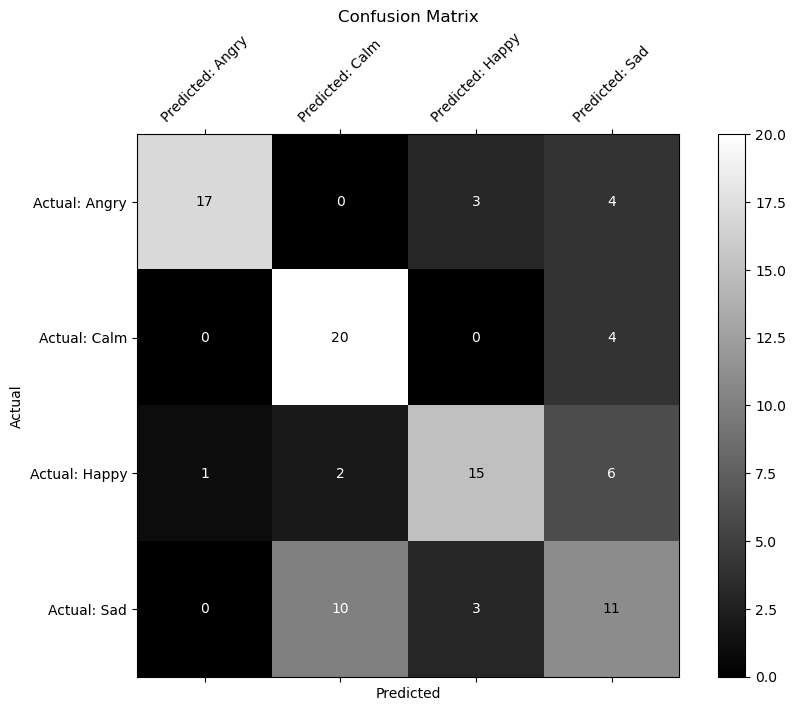

In [18]:
# y_test_male and y_pred_male are your true and predicted labels
cm_m = confusion_matrix(y_test_male, y_pred_m)

# Create a DataFrame from the confusion matrix array
cm_df_m = pd.DataFrame(cm_m,
                     index=['Actual: Angry', 'Actual: Calm', 'Actual: Happy', 'Actual: Sad'],
                     columns=['Predicted: Angry', 'Predicted: Calm', 'Predicted: Happy', 'Predicted: Sad'])

#                     index=['Actual: Angry', 'Actual: Calm', 'Actual: Disgust', 'Actual: Fearful', 'Actual: Happy', 'Actual: Sad', 'Actual: Surprised'],
#                     columns=['Predicted: Angry', 'Predicted: Calm', 'Predicted: Disgust', 'Predicted: Fearful', 'Predicted: Happy', 'Predicted: Sad', 'Predicted: Surprised'])


# Plotting the matrix plot
plt.figure(figsize=(10, 7))
plt.matshow(cm_m, cmap='gray', fignum=1)
plt.colorbar()
plt.xticks(ticks=range(len(cm_df_m.columns)), labels=cm_df_m.columns, rotation=45)
plt.yticks(ticks=range(len(cm_df_m.index)), labels=cm_df_m.index)

# Adding annotations with dynamic color
threshold = cm_m.max() / 2  # Threshold for changing text color
for i in range(len(cm_m)):
    for j in range(len(cm_m[i])):
        color = 'black' if cm_m[i, j] > threshold else 'white'
        plt.text(j, i, str(cm_m[i][j]), ha='center', va='center', color=color)

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
# Creating a pipeline that first applies the StandardScaler and then fits the MLPClassifier
# Best accuracy: 0.5178571428571429
# alpha=0.42, activation='tanh', solver='lbfgs', learning_rate_init=0.0003,
#                           batch_size=163, epsilon=1e-08, hidden_layer_sizes=(600, ), max_iter=2000

# Best Parameters: {'mlp__solver': 'adam', 'mlp__max_iter': 2000, 
#                   'mlp__learning_rate_init': 0.00026000000000000003, 
#                   'mlp__hidden_layer_sizes': (300,), 'mlp__batch_size': 163, 
#                   'mlp__alpha': 1.375, 'mlp__activation': 'relu'}


# MLPClassifier hyper-parameter options
# hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', 
# learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
# random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
# early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
# n_iter_no_change=10, max_fun=15000

# Splitting actors for training and testing
train_female = [2, 4, 6, 14, 16, 18, 20, 22, 24]
test_female = [8, 10, 12]

# Split the dataframe based on actor numbers
train_df_f = df_female[df_female['actor_number'].isin(train_female)]
test_df_f = df_female[df_female['actor_number'].isin(test_female)]

# Define features and target for the train and test sets
X_train_female = train_df_f[feature_female]
y_train_female = train_df_f['emotion']
X_test_female = test_df_f[feature_female]
y_test_female = test_df_f['emotion']

# Define the pipeline
pipeline_f = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(alpha=1.6, activation='tanh', solver='adam', learning_rate_init=0.00027, 
                          batch_size=163, epsilon=1e-08, hidden_layer_sizes=(1200, ), max_iter=2000))
])

# Fit the pipeline to the training data
pipeline_f.fit(X_train_female, y_train_female)

# Evaluate the model on the testing set
y_pred_f = pipeline_f.predict(X_test_female)
print(confusion_matrix(y_test_female, y_pred_f))
print(classification_report(y_test_female, y_pred_f))
accuracy_f = accuracy_score(y_test_female, y_pred_f)
print("Accuracy:", accuracy_f)

[[17  0  7  0]
 [ 1 10  1 12]
 [ 0  0 24  0]
 [ 3  4  7 10]]
              precision    recall  f1-score   support

       angry       0.81      0.71      0.76        24
        calm       0.71      0.42      0.53        24
       happy       0.62      1.00      0.76        24
         sad       0.45      0.42      0.43        24

    accuracy                           0.64        96
   macro avg       0.65      0.64      0.62        96
weighted avg       0.65      0.64      0.62        96

Accuracy: 0.6354166666666666


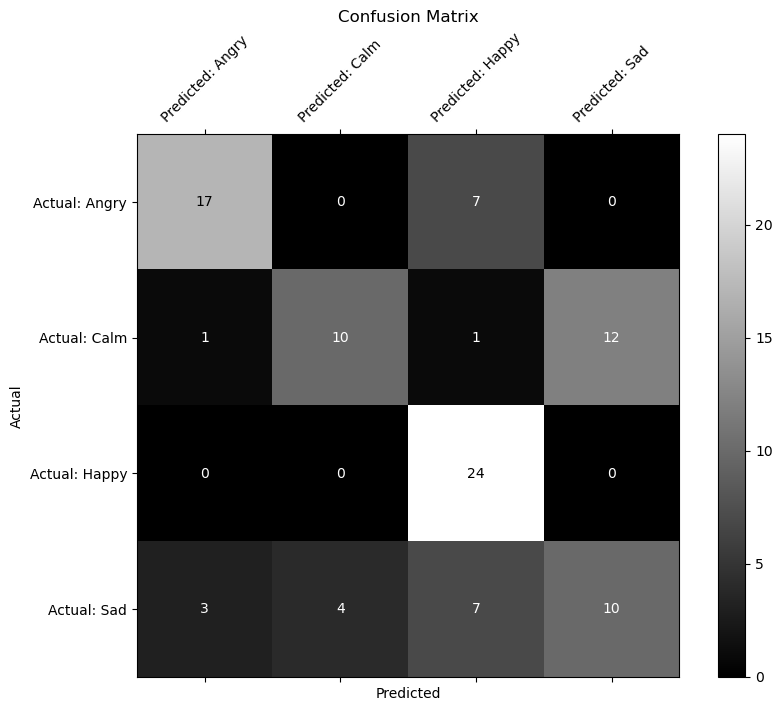

In [20]:
# y_test_female and y_pred_female are true and predicted labels
cm_f = confusion_matrix(y_test_female, y_pred_f)

# Create a DataFrame from the confusion matrix array
cm_df_f = pd.DataFrame(cm_f, 
                     index=['Actual: Angry', 'Actual: Calm', 'Actual: Happy', 'Actual: Sad'],
                     columns=['Predicted: Angry', 'Predicted: Calm', 'Predicted: Happy', 'Predicted: Sad'])

#                     index=['Actual: Angry', 'Actual: Calm', 'Actual: Disgust', 'Actual: Fearful', 'Actual: Happy', 'Actual: Sad', 'Actual: Surprised'],
#                     columns=['Predicted: Angry', 'Predicted: Calm', 'Predicted: Disgust', 'Predicted: Fearful', 'Predicted: Happy', 'Predicted: Sad', 'Predicted: Surprised'])

# Plotting the matrix plot
plt.figure(figsize=(10, 7))
plt.matshow(cm_f, cmap='gray', fignum=1)
plt.colorbar()
plt.xticks(ticks=range(len(cm_df_f.columns)), labels=cm_df_f.columns, rotation=45)
plt.yticks(ticks=range(len(cm_df_f.index)), labels=cm_df_f.index)

# Adding annotations with dynamic color
threshold = cm_f.max() / 2  # Threshold for changing text color
for i in range(len(cm_f)):
    for j in range(len(cm_f[i])):
        color = 'black' if cm_f[i, j] > threshold else 'white'
        plt.text(j, i, str(cm_f[i][j]), ha='center', va='center', color=color)

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

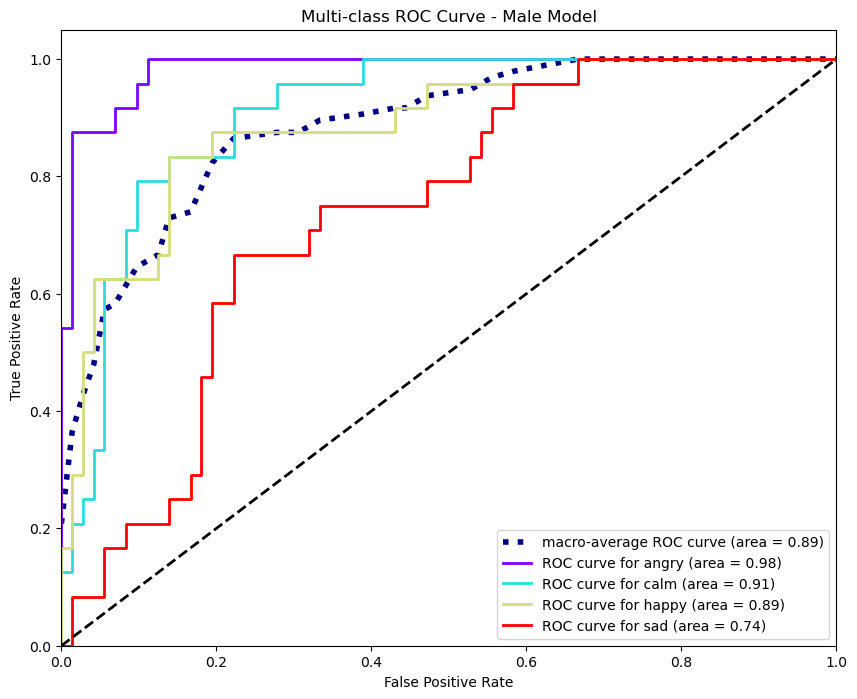

In [21]:
# Define the emotion classes
emotion_classes = pipeline_m.classes_

# Binarize the labels for the male dataset
y_test_male_binarized = label_binarize(y_test_male, classes=emotion_classes)
n_classes_male = y_test_male_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr_male = dict()
tpr_male = dict()
roc_auc_male = dict()

y_prob = pipeline_m.predict_proba(X_test_male)

for i in range(n_classes_male):
    fpr_male[i], tpr_male[i], _ = roc_curve(y_test_male_binarized[:, i], y_prob[:, i])
    roc_auc_male[i] = auc(fpr_male[i], tpr_male[i])

# Compute micro-average ROC curve and ROC area
fpr_male["micro"], tpr_male["micro"], _ = roc_curve(y_test_male_binarized.ravel(), y_prob.ravel())
roc_auc_male["micro"] = auc(fpr_male["micro"], tpr_male["micro"])

# Aggregate all false positive rates
all_fpr_male = np.unique(np.concatenate([fpr_male[i] for i in range(n_classes_male)]))

# Interpolate all ROC curves at these points
mean_tpr_male = np.zeros_like(all_fpr_male)
for i in range(n_classes_male):
    mean_tpr_male += np.interp(all_fpr_male, fpr_male[i], tpr_male[i])

# Average it and compute AUC
mean_tpr_male /= n_classes_male

fpr_male["macro"] = all_fpr_male
tpr_male["macro"] = mean_tpr_male
roc_auc_male["macro"] = auc(fpr_male["macro"], tpr_male["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot macro-average ROC curve
plt.plot(fpr_male["macro"], tpr_male["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_male["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes_male)))
for i, color in zip(range(n_classes_male), colors):
    plt.plot(fpr_male[i], tpr_male[i], color=color, lw=2,
             label='ROC curve for {0} (area = {1:0.2f})'.format(emotion_classes[i], roc_auc_male[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Male Model')
plt.legend(loc="lower right")
plt.show()

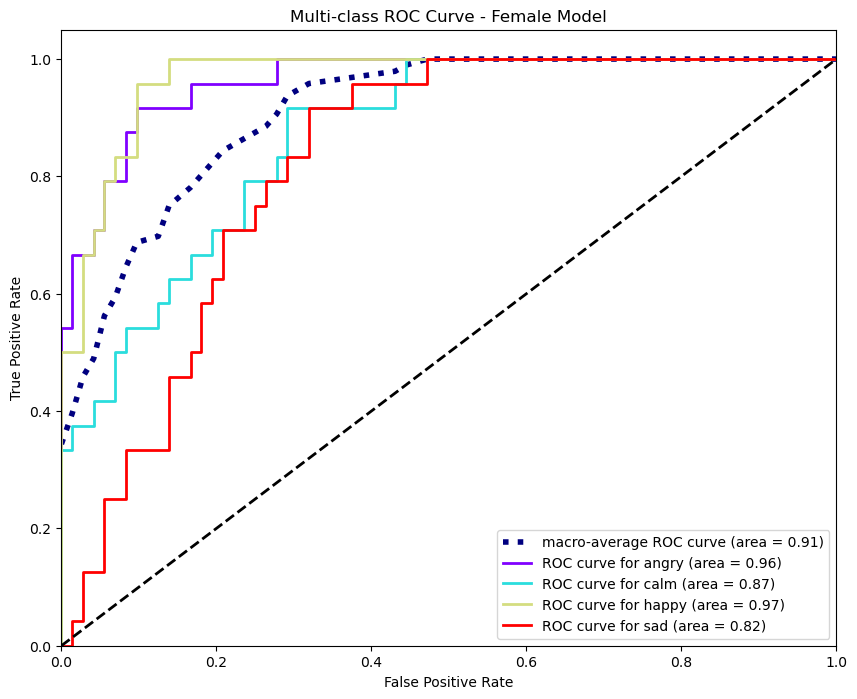

In [22]:
# Define the emotion classes
emotion_classes = pipeline_f.classes_

# Binarize the labels for the male dataset
y_test_female_binarized = label_binarize(y_test_female, classes=emotion_classes)
n_classes_female = y_test_female_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr_female = dict()
tpr_female = dict()
roc_auc_female = dict()

y_prob_f = pipeline_f.predict_proba(X_test_female)

for i in range(n_classes_female):
    fpr_female[i], tpr_female[i], _ = roc_curve(y_test_female_binarized[:, i], y_prob_f[:, i])
    roc_auc_female[i] = auc(fpr_female[i], tpr_female[i])

# Compute micro-average ROC curve and ROC area
fpr_female["micro"], tpr_female["micro"], _ = roc_curve(y_test_female_binarized.ravel(), y_prob_f.ravel())
roc_auc_female["micro"] = auc(fpr_female["micro"], tpr_female["micro"])

# Aggregate all false positive rates
all_fpr_female = np.unique(np.concatenate([fpr_female[i] for i in range(n_classes_female)]))

# Interpolate all ROC curves at these points
mean_tpr_female = np.zeros_like(all_fpr_female)
for i in range(n_classes_female):
    mean_tpr_female += np.interp(all_fpr_female, fpr_female[i], tpr_female[i])

# Average it and compute AUC
mean_tpr_female /= n_classes_female

fpr_female["macro"] = all_fpr_female
tpr_female["macro"] = mean_tpr_female
roc_auc_female["macro"] = auc(fpr_female["macro"], tpr_female["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot macro-average ROC curve
plt.plot(fpr_female["macro"], tpr_female["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_female["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes_female)))
for i, color in zip(range(n_classes_female), colors):
    plt.plot(fpr_female[i], tpr_female[i], color=color, lw=2,
             label='ROC curve for {0} (area = {1:0.2f})'.format(emotion_classes[i], roc_auc_female[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Female Model')
plt.legend(loc="lower right")
plt.show()

Success rates dropped once the data leak was fixed but the results aren't bad. For an inconsistant data type like human 
emotion. The ROC curves aren't bad either. When only looking at 4 classes, (angry, calm, happy, sad), there is an increase in 
`success rate, above 60%. This may start to approach usuability in an environment to identify emotion in a streaming audio situation like call center calls for instance.